Нужно научиться определять рыночную стоимость объектов недвижимости, задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

## Изучение данных 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns=40
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
try: 
    data = pd.read_csv('datasets/real_estate_data.csv', sep='\t', decimal=',')
except: 
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

In [5]:
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


- Видим общее число записей: 23699, все столбцы названы корректно, переименование не требуется. 
- В некоторых столбцах существуют пропуски данных (высота потолков, жилая площадь, всего этажей в доме, апартаменты ли, площадь кухни, наличие балкона, расстояние до центра, расстояние до ближайшего парка, водоема, количество дней, пока публиковалось объявление и т.д.), требуется работа с пропусками. 
- Некоторые столбцы имеют некорректный формат данных (цена продажи, общая площадь, дата опубликования, высота потолков, всего этажей, общая площаь, апартаменты ли, площадь кухни, кол-во балконов, расстояние до аэропорта, парка, водоема и т.д. - все это строки вместо чисел), требуется работа с форматами данных. 

## Предобработка данных

### Пропуски 

В столбцах total_images, last_price, total_area, first_day_exposition и rooms пропусков нет. Посмотрим в первом приближении на данные о цене, площади и дате размещения объявления.

In [6]:
data['last_price']=pd.to_numeric(data['last_price'])
data['total_area']=pd.to_numeric(data['total_area'])

Посмотрим на меры разброса и центральной тенденции по числовым столбцам

In [7]:
data.describe()

,total_images,last_price,total_area,rooms,floor
count,23699.00,23699.00,23699.00,23699.00,23699.00
mean,9.86,6541548.77,60.35,2.07,5.89
std,5.68,10887013.27,35.65,1.08,4.89
min,0.00,12190.00,12.00,0.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.00
50%,9.00,4650000.00,52.00,2.00,4.00
75%,14.00,6800000.00,69.90,3.00,8.00
max,50.00,763000000.00,900.00,19.00,33.00


Видим, что в данных о цене есть необычайно низкие и необычайно высокие значения. Изучим их подробнее на шаге построения диаграмм. Цена - это один из ключевых столбцов, и необходимо его подробно исследовать. То же касается и площади (общей, а также квадратного метра): 

#### ceiling_height

В столбце ceiling_height есть большое количество пропущенных данных, также формат данных в этом столбце - object.

In [8]:
data['ceiling_height'].isnull().sum()

9195

In [9]:
data['ceiling_height']=pd.to_numeric(data['ceiling_height'])

In [10]:
data['ceiling_height'].describe()

count   14504.00
mean        2.77
std         1.26
min         1.00
25%         2.52
50%         2.65
75%         2.80
max       100.00
Name: ceiling_height, dtype: float64

Максимальное значение выглядит странно (вряд ли высота потолка в каком-либо жилом помещении будет 100 метров), а медиана в размере 2.65 - стандартная. Заменим пропущенные значения медианными. 

In [11]:
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())

In [12]:
data['ceiling_height'].isnull().sum()

0

#### floors_total

В столбце floors_total также есть пропуски. Их незначительное количество. Поступим аналогично. 

In [13]:
data['floors_total'].isnull().sum()

86

In [14]:
data['floors_total']=pd.to_numeric(data['floors_total'])
data['floors_total'].describe()

count   23613.00
mean       10.67
std         6.60
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

In [15]:
data['floors_total']=data['floors_total'].fillna(data['floors_total'].median())

In [16]:
data['floors_total'].isnull().sum()

0

####  living_area

В столбце living_area также есть пропуски. Их нельзя заменить на среднее, т.к. для жилой площади есть ограничение - общая площадь. Найдем отношение жилой площади к общей площади для тех строк, где нет пропусков, затем внесем это значение в новый столбец, найдем медианный показатель и используем его - в обратном порядке, умножая на него общую площадь - для заполнения пропусков в данных жилой площади, ведь данные об общей площади заполнены все. 

In [17]:
data['living_area'].isna().sum()

1903

In [18]:
data['living_area']=pd.to_numeric(data['living_area'])

In [19]:
data['living_area_ratio']=data['living_area'] / data['total_area']
median_living_area_ratio=data['living_area_ratio'].median()
median_living_area_ratio

0.5678598992678503

In [20]:
data['living_area']=data['living_area'].fillna(data['total_area']*median_living_area_ratio)
data['living_area'].isna().sum()

0

In [21]:
data['living_area'].describe()

count   23699.00
mean       34.58
std        22.34
min         2.00
25%        19.00
50%        30.00
75%        42.10
max       409.70
Name: living_area, dtype: float64

#### is_apartment

Столбец is_apartment должен иметь булев тип, то есть True/False. Посмотрим, какие данные указаны и почему тип данных object. 

In [22]:
data['is_apartment'].isna().sum()

20924

In [23]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

На самом деле апартаментов вообще немного, поэтому сочтем, что там, где этот столбец не заполнен, это означает "не апартаменты" и заменим пропущенные значения на False. 

In [24]:
data['is_apartment']=data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

In [25]:
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

####  kitchen_area

С пропущенными данными в kitchen_area поступим аналогично living_area

In [26]:
data['kitchen_area'].isna().sum()

2278

In [27]:
data['kitchen_area']=pd.to_numeric(data['kitchen_area'])

In [28]:
data['kitchen_area_ratio']=data['kitchen_area'] / data['total_area']
median_kitchen_area_ratio=data['kitchen_area_ratio'].median()
median_kitchen_area_ratio

0.1724137931034483

In [29]:
data['kitchen_area']=data['kitchen_area'].fillna(data['total_area']*median_kitchen_area_ratio)
data['kitchen_area'].isna().sum()

0

In [30]:
data['kitchen_area'].describe()

count   23699.00
mean       10.49
std         6.03
min         1.30
25%         7.00
50%         9.00
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

С данными в balcony поступим аналогично с данными в apartment. Вероятнее всего, данные о балконе не заполнены потому, что балкона нет. 

In [31]:
data['balcony'].isna().sum()

11519

In [32]:
data['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [33]:
data['balcony']=data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

In [34]:
data['balcony']=pd.to_numeric(data['balcony'])
data['balcony'].value_counts()

0.00    15277
1.00     4195
2.00     3659
5.00      304
4.00      183
3.00       81
Name: balcony, dtype: int64

####  locality_name

Незаполненные данные в столбце locality_name

In [35]:
data['locality_name'].isna().sum()

49

Ради 49 записей можно было и не создавать такой алгоритм, и просто указать "Санкт-Петербург", но посмотрим, какие значения принимает для них расстояние до центра. 

In [36]:
data['locality_name']=data['locality_name'].fillna('Неизвестно')

In [37]:
data['cityCenters_nearest']=pd.to_numeric(data['cityCenters_nearest'])
data_unknown_locality = data[data['locality_name'].isna()]
print('От', data_unknown_locality['cityCenters_nearest'].min(), ', до', data_unknown_locality['cityCenters_nearest'].max())

От nan , до nan


Поймем, какое расстояние до центра у тех записей, центром которых указан Санкт-Петербург. 

In [38]:
data_spb_locality=data.loc[data['locality_name']=="Санкт-Петербург"]
print('От', data_spb_locality['cityCenters_nearest'].min(), 'до', data_spb_locality['cityCenters_nearest'].max())

От 181.0 до 29493.0


In [39]:
data_spb_locality.shape

(15721, 24)

Узнаем, сколько записей с неизвестным центром дальше, чем самая дальняя от центра города квартира. 

In [40]:
display(data_spb_locality['cityCenters_nearest'].max())
data.loc[
    (data['locality_name'].isna()) & (data['cityCenters_nearest']
                                       > data_spb_locality['cityCenters_nearest'].max())
]

29493.0

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio


Их всего три, поэтому для всех данных, где населенный пункт не указан, укажем "Санкт-Петербург". 

In [41]:
data.loc[data['locality_name']=='Неизвестно', 'locality_name']='Санкт-Петербург'

In [42]:
data['locality_name'].value_counts()

Санкт-Петербург                    15770
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

In [43]:
data['locality_name'].isna().sum()

0

Теперь проверим дубликаты в названиях населенных пунктов. Они возможны там из-за разницы написания названий.

In [44]:
locality_name_list=data['locality_name'].unique().tolist()
print(*locality_name_list, sep=', ')

Санкт-Петербург, посёлок Шушары, городской посёлок Янино-1, посёлок Парголово, посёлок Мурино, Ломоносов, Сертолово, Петергоф, Пушкин, деревня Кудрово, Коммунар, Колпино, поселок городского типа Красный Бор, Гатчина, поселок Мурино, деревня Фёдоровское, Выборг, Кронштадт, Кировск, деревня Новое Девяткино, посёлок Металлострой, посёлок городского типа Лебяжье, посёлок городского типа Сиверский, поселок Молодцово, поселок городского типа Кузьмоловский, садовое товарищество Новая Ропша, Павловск, деревня Пикколово, Всеволожск, Волхов, Кингисепп, Приозерск, Сестрорецк, деревня Куттузи, посёлок Аннино, поселок городского типа Ефимовский, посёлок Плодовое, деревня Заклинье, поселок Торковичи, поселок Первомайское, Красное Село, посёлок Понтонный, Сясьстрой, деревня Старая, деревня Лесколово, посёлок Новый Свет, Сланцы, село Путилово, Ивангород, Мурино, Шлиссельбург, Никольское, Зеленогорск, Сосновый Бор, поселок Новый Свет, деревня Оржицы, деревня Кальтино, Кудрово, поселок Романовка, посёло

In [45]:
len(data['locality_name'].unique().tolist())

364

Очевидно, что дубликаты есть из-за букв "е" и "ё". Например, "посёлок Пансионат Зелёный Бор" и др.

In [46]:
data['locality_name']=data['locality_name'].str.replace('ё', 'е', regex=True)

In [47]:
print(data['locality_name'].unique().tolist())

['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1', 'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино', 'поселок городского типа Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск', 'деревня Новое Девяткино', 'поселок Металлострой', 'поселок городского типа Лебяжье', 'поселок городского типа Сиверский', 'поселок Молодцово', 'поселок городского типа Кузьмоловский', 'садовое товарищество Новая Ропша', 'Павловск', 'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино', 'поселок городского типа Ефимовский', 'поселок Плодовое', 'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское', 'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая', 'деревня Лесколово', 'поселок Новый Свет', 'Сланцы', 'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург', 'Никольское', 'Зеленогорск', 'Сосновый Бор

In [48]:
len(data['locality_name'].unique().tolist())

330

#### airports_nearest

Незаполненные данные в столбце airports_nearest

Оставим эти данные незаполненными, т.к. у нас нет технической возможности определить это расстояние (например, с помощью сервиса карт, у нас нет адреса продаваемой недвижимости в Санкт-Петербурге), а по отдалению квартиры от центра это определить невозможно, т.к. аэропорт находится на южном краю города на расстоянии около 18 км от центра. 

#### cityCenters_nearest

Незаполненные данные в столбце cityCenters_nearest (расстояние до центра города).

In [49]:
data['cityCenters_nearest'].isna().sum()

5519

In [50]:
data['cityCenters_nearest'].describe()

count   18180.00
mean    14191.28
std      8608.39
min       181.00
25%      9238.00
50%     13098.50
75%     16293.00
max     65968.00
Name: cityCenters_nearest, dtype: float64

Посмотрим, какое среднее расстояние до центра С-Петербурга указано для этих населенных пунктов в таблице.

In [51]:
data_cityCenters_nearest_pivot=data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='median')
data_cityCenters_nearest_pivot.sort_values(by='cityCenters_nearest', ascending=False)

,cityCenters_nearest
locality_name,
поселок Молодежное,65764.00
Зеленогорск,53381.00
Ломоносов,51677.00
Кронштадт,49575.00
поселок Репино,42896.50
поселок Белоостров,38868.00
поселок Саперный,35859.50
Сестрорецк,34821.00
поселок Щеглово,34085.00


Это соответствует действительности. А для других населенных пунктов, очевидно, это значение не заполнено. Если бы мы изучали влияние на цену квадратного метра расстояния до центра Санкт-Петербурга от населенных пунктов Ленинградской области, то мы бы попросили выгрузить эти данные из Яндекс-Карт :) или создали такую таблицу вручную, с точностью до нескольких километров, используя карты и линейку. В данном случае это трудоемко, и во второй части исследования мы рассматриваем только влияние этого расстояния на цену недвижимости, расположенную в Санкт-Петербурге, поэтому оставим эти значения пустыми и проверим только Санкт-Петербург. 

In [52]:
spb_locality_data=data.loc[data['locality_name']=="Санкт-Петербург"]
spb_locality_data['cityCenters_nearest'].isna().sum()

69

Итак, среди 15770 объявлений для Санкт-Петербурга расстояние не заполнено менее, чем для 0.4% объявлений. <br>
Заполним вручную эти пропуски медианным значением. 

In [53]:
data.loc[
    data['locality_name']=='Санкт-Петербург', 'cityCenters_nearest'] = data.loc[
    data['locality_name']=='Санкт-Петербург','cityCenters_nearest'].fillna(
    data.loc[data['locality_name']=='Санкт-Петербург', 'cityCenters_nearest'].median()
)

In [54]:
spb_locality_data=data.query('locality_name=="Санкт-Петербург"')
spb_locality_data['cityCenters_nearest'].isna().sum()

0

#### parks_around3000

Незаполненные данные в столбце parks_around3000

In [55]:
data['parks_around3000'].isna().sum()

5518

In [56]:
data['parks_around3000'].value_counts()

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

Вероятно, что если данные в этом столбце не заполнены, парков на расстояниее 3 км нет. Поэтому заменим пропуски на 0. 

In [57]:
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

In [58]:
data['parks_around3000']=pd.to_numeric(data['parks_around3000'])
data['parks_around3000'].value_counts()

0.00    15624
1.00     5681
2.00     1747
3.00      647
Name: parks_around3000, dtype: int64

#### parks_nearest

Незаполненные данные в столбце parks_nearest

Оставим эти данные незаполненными, т.к. у нас нет технической возможности определить это расстояние (например, с помощью сервиса карт, у нас нет адреса продаваемой недвижимости).

#### ponds_around3000

Незаполненные данные в столбце ponds_around3000. Поступим в точности как со столбцом parks_around3000. 

In [59]:
data['ponds_around3000'].isna().sum()

5518

In [60]:
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

In [61]:
data['ponds_around3000']=pd.to_numeric(data['ponds_around3000'])
data['ponds_around3000'].value_counts()

0.00    14589
1.00     5717
2.00     1892
3.00     1501
Name: ponds_around3000, dtype: int64

#### ponds_nearest

Незаполненные данные в столбце ponds_nearest 

Оставим эти данные незаполненными, т.к. у нас нет технической возможности определить это расстояние (например, с помощью сервиса карт, у нас нет адреса продаваемой недвижимости).

#### days_exposition

Незаполненные данные в столбце days_exposition 

In [62]:
data['days_exposition'].isna().sum()

3181

In [63]:
data['days_exposition']=pd.to_numeric(data['days_exposition'])
data['days_exposition'].describe()

count   20518.00
mean      180.89
std       219.73
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

Поскольку в дальнейшем мы будем изучать длительность продажи отдельно, оставим эти данные незаполненными. 

#### rooms

Посмотрим на данные о числе комнат:

In [64]:
data['rooms'].describe()

count   23699.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

#### studio, open_plan

Данные о студии и открытой планировке:

In [65]:
data['studio'].value_counts()

False    23550
True       149
Name: studio, dtype: int64

In [66]:
data['open_plan'].value_counts()

False    23632
True        67
Name: open_plan, dtype: int64

### Типы данных

Кое-где мы уже изменили типы данных, пока заполняли пропущенные ячейки. Посмотрим, что осталось. 

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Для first_day_exposition формат данных строка. Превратим его в дату и посмотрим диапазон дат.  

In [68]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [69]:
print('Самая ранняя дата публикации', data['first_day_exposition'].min())

Самая ранняя дата публикации 2014-11-27 00:00:00


In [70]:
print('Самая поздняя дата публикации', data['first_day_exposition'].max())

Самая поздняя дата публикации 2019-05-03 00:00:00


Исправим формат данных для airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest со строки на число, т.к. это расстояние в метрах. Оставим float, т.к. там есть пропуски в данных (NaN). 

In [71]:
data['airports_nearest']=pd.to_numeric(data['airports_nearest'])
data['cityCenters_nearest']=pd.to_numeric(data['cityCenters_nearest'])
data['parks_nearest']=pd.to_numeric(data['parks_nearest'])
data['ponds_nearest']=pd.to_numeric(data['ponds_nearest'])

Исправим формат данных для balcony, floors_total, parks_around3000, ponds_around3000 на int, т.к. все это целые числа.

In [72]:
data['balcony']=data['balcony'].astype('int')
data['floors_total']=data['floors_total'].astype('int')
data['parks_around3000']=data['parks_around3000'].astype('int')
data['ponds_around3000']=data['ponds_around3000'].astype('int')

Формат данных days_exposition - строка. Превратим в numeric (float), ведь есть пропущенные данные (NaN). 

In [73]:
data['days_exposition']=pd.to_numeric(data['days_exposition'])

In [74]:
data['days_exposition'].describe()

count   20518.00
mean      180.89
std       219.73
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

Проверим результат. 

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Данные приведены к желаемому формату, пропуски в данных оставлены только там, где правильнее оставить пустые значения как они есть. 

### Дубликаты

Проверим дубликаты строк в data.

In [76]:
data.duplicated().sum()

0

Дубликаты в датафрейме data отсутствуют.

### Вывод

Мы заполнили пропуски или оставили пропущенные данные без изменения - там, где это уместно, изменили тип данных и проверили отсутствие дубликатов строк. 

## Расчёты и добавление результатов в таблицу

### Цена квадратного метра

Добавим в таблицу цену квадратного метра и посмотрим общую информацию об этом столбце.

In [77]:
data['square_meter_price']=(data['last_price']) / (data['total_area'])

In [78]:
data['square_meter_price'].describe()

count     23699.00
mean      99421.66
std       50306.80
min         111.83
25%       76585.47
50%       95000.00
75%      114256.33
max     1907500.00
Name: square_meter_price, dtype: float64

Общая информация здесь малоинформативна, т.к. средняя цена квадратного метра явно зависит от множества факторов, и соответственно, при группировке данных по разным признакам будет различной. Это мы изучим далее. 

### День недели, месяц, год публикации объявления

Добавим в таблицу день недели, месяц и год публикации объявления

In [79]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_exposition'] = pd.DatetimeIndex(data ['first_day_exposition']).year

In [80]:
data['weekday_exposition'].value_counts()

3    4295
1    4183
4    4000
2    3974
0    3612
5    1936
6    1699
Name: weekday_exposition, dtype: int64

In [81]:
data['month_exposition'].value_counts()

2     2640
3     2587
4     2379
11    2371
10    2127
9     1981
6     1760
8     1744
7     1695
12    1641
1     1500
5     1274
Name: month_exposition, dtype: int64

Весной и осенью размещается больше объявлений, летом, перед и после нового года - меньше. 

In [82]:
data['year_exposition'].value_counts()

2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year_exposition, dtype: int64

Данные представлены с 2014 по 2019 г., ранее мы узнали, что с ноября 2014 по май 2019 г., в рамках полных лет: с 2015 по 2018 количество поданных объявлений в год постоянно растет. 

### Этаж: категория

Добавим в таблицу категорию этажа квартиры (варианты — первый, последний, другой)

In [83]:
data['floor'].describe()

count   23699.00
mean        5.89
std         4.89
min         1.00
25%         2.00
50%         4.00
75%         8.00
max        33.00
Name: floor, dtype: float64

Распределение по этажам (с номерами этажей):

In [84]:
data['floor'].value_counts()

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
30       1
29       1
32       1
33       1
31       1
Name: floor, dtype: int64

Большинство квартир не выше 9-го этажа, квартир выше 26-го этажа - единицы. 

In [85]:
def floor_description(row): 
    if row['floors_total']==row['floor']: 
        return 'последний этаж'
    if row['floor']==1: 
        return 'первый этаж'
    return 'другой этаж'

data['floor_category']=data.apply(floor_description, axis=1)

In [86]:
data['floor_category'].value_counts()

другой этаж       17441
последний этаж     3366
первый этаж        2892
Name: floor_category, dtype: int64

Для того, чтобы в дальнейшем обрабатывать это разделение на категории этажей, добавим идентификатор категории (числовой): 1 - для первого этажа, 2 - для "другого" этажа и 3 - для последнего. 

In [87]:
def floor_category_identify(row): 
    if row['floor_category']=='последний этаж': 
        return 3
    if row['floor_category']=='первый этаж': 
        return 1
    return 2

data['floor_category_id']=data.apply(floor_category_identify, axis=1)

### Соотношение площадей

Соотношение жилой и общей площади рассчитывалось нами ранее и содержалось в столбце living_area_ratio. Там были пропуски из-за пропусков данных. Теперь эти пропуски заменены, и мы заменим данные в столбце новыми. 

In [88]:
data['living_area_ratio']=(data['living_area'])/(data['total_area'])

In [89]:
data['living_area_ratio'].describe()

count   23699.00
mean        0.57
std         0.10
min         0.02
25%         0.50
50%         0.57
75%         0.63
max         1.00
Name: living_area_ratio, dtype: float64

Аналогично столбец kitchen_area_ratio. 

In [90]:
data['kitchen_area_ratio']=(data['kitchen_area'])/(data['total_area'])

In [91]:
data['kitchen_area_ratio'].describe()

count   23699.00
mean        0.19
std         0.07
min         0.03
25%         0.14
50%         0.17
75%         0.22
max         0.79
Name: kitchen_area_ratio, dtype: float64

Посмотрим результат:

In [92]:
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,NaN,0.47,0.23,120370.37,3,3,2019,другой этаж,2
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.00,18603.00,0,NaN,0,NaN,81.00,0.46,0.27,82920.79,1,12,2018,первый этаж,1
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558.00,0.61,0.15,92785.71,3,8,2015,другой этаж,2


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

## Исследовательский анализ данных

### Площадь, цена, число комнат, высота потолков.

#### Площадь общая

In [94]:
data['total_area'].describe()

count   23699.00
mean       60.35
std        35.65
min        12.00
25%        40.00
50%        52.00
75%        69.90
max       900.00
Name: total_area, dtype: float64

- Средняя площадь квартир 52 кв м (медиана) / 60 кв м (среднее). 
- Разброс данных велик: 35 кв м. 
- Есть небольшие квартиры: 12 м. и очень большие - 900 кв. м. 

<AxesSubplot:>

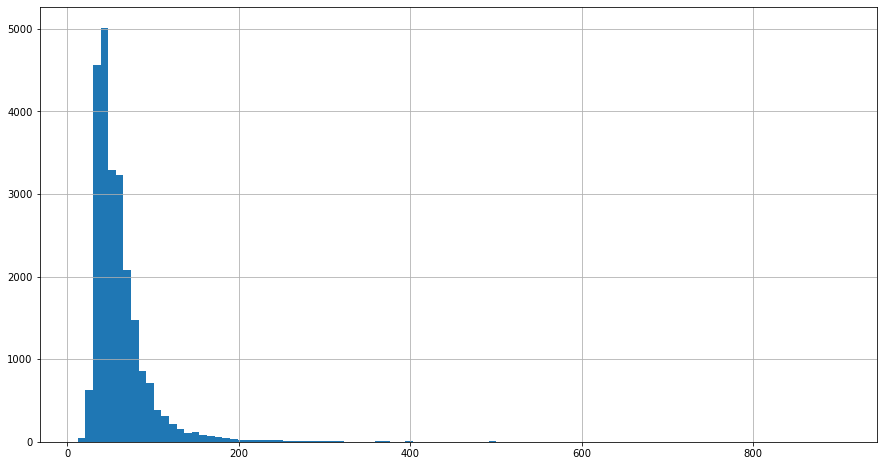

In [95]:
data['total_area'].hist(bins=100, figsize=(15,8), grid=True)

Посмотрим распределение площади в пределах от 12 до 200 метров. 

<AxesSubplot:>

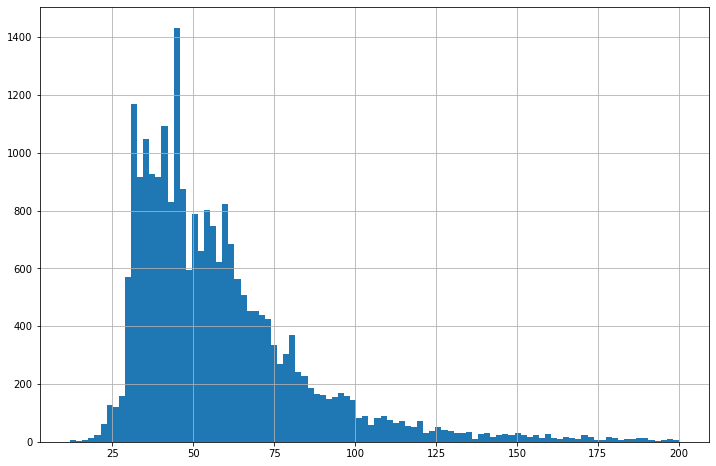

In [96]:
data['total_area'].hist(bins=100, figsize=(12,8), grid=True, range=(12,200))

На определенных значениях есть пики и падения гистограммы, что связано, очевидно, с тем, что большинство квартир имеют стандартные планировки, поэтому квартир с площадью, например, 46 кв.м. может быть много, а 49 кв. м. - намного меньше, хотя площадь отличается ненамного. 

Квартир какой площади больше всего?

In [97]:
data_pivot_total_area=data.pivot_table(index='total_area', values='living_area', aggfunc='count')
data_pivot_total_area.sort_values(by='living_area', ascending=False).head(10)

,living_area
total_area,
45.00,419
42.00,383
60.00,347
31.00,346
44.00,345
40.00,315
43.00,301
32.00,289
46.00,282


45, 42 и 60 квадратных метров общей площади

#### Жилая площадь

In [98]:
data['living_area'].describe()

count   23699.00
mean       34.58
std        22.34
min         2.00
25%        19.00
50%        30.00
75%        42.10
max       409.70
Name: living_area, dtype: float64

Средняя жилая площадь 30-34 кв м., от 2 до 410 кв м. Показатель жилой площади, порой, является техническим показателем (в документах) и не отражать фактическую полезную площадь квартиры (например, той, где есть большой коридор или кухня, используемая как гостиная или осуществлена перепланировка). 

<AxesSubplot:>

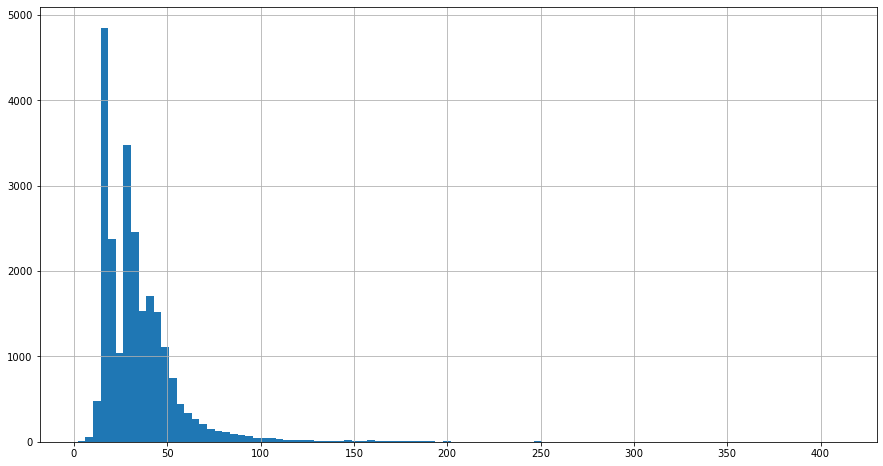

In [99]:
data['living_area'].hist(bins=100, figsize=(15,8))

Посмотрим, как распределяется жилая площадь в диапазоне от 2 до 100 м. 

<AxesSubplot:>

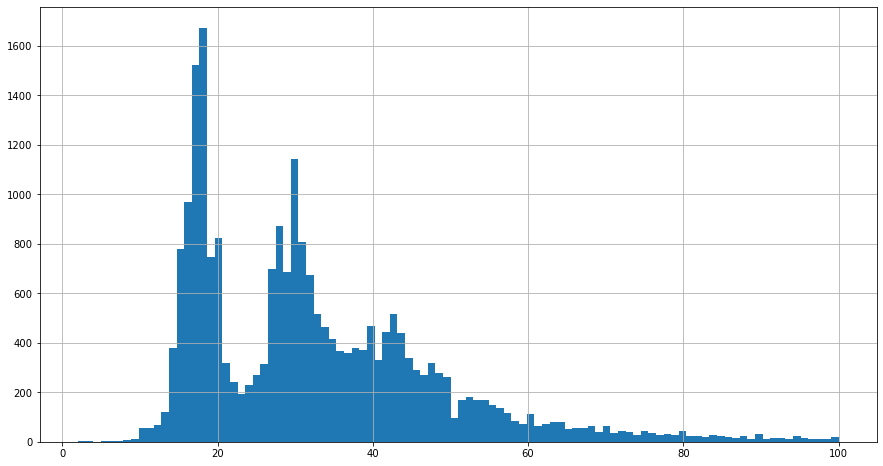

In [100]:
data['living_area'].hist(bins=100, figsize=(15,8), grid=True, range=(2,100))

In [101]:
data_pivot_living_area=data.pivot_table(index='living_area', values='total_area', aggfunc='count')
data_pivot_living_area.sort_values(by='total_area', ascending=False).head(10)

,total_area
living_area,
18.00,882
17.00,675
30.00,598
16.00,486
20.00,481
28.00,423
31.00,381
19.00,329
32.00,320


Очевидно, что разница в количества близлежащих квадратных метров связана также со стандартными планировками. 

#### Площадь кухни

In [102]:
data['kitchen_area'].describe()

count   23699.00
mean       10.49
std         6.03
min         1.30
25%         7.00
50%         9.00
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

<AxesSubplot:>

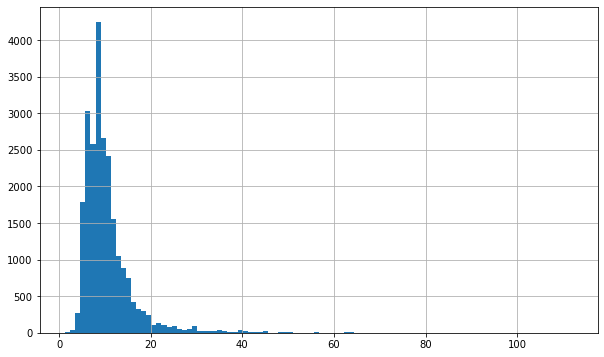

In [103]:
data['kitchen_area'].hist(bins=100, figsize=(10,6))

In [104]:
data_pivot_kitchen_area=data.pivot_table(index='kitchen_area', values='total_area', aggfunc='count')
data_pivot_kitchen_area.sort_values(by='total_area', ascending=False).head(10)

,total_area
kitchen_area,
6.00,1300
10.00,1283
8.00,1113
9.00,1101
7.00,1062
11.00,798
12.00,662
8.50,415
5.50,403


Самое большое количество кухонь - 6-,8- и 10-метровые - стандарт застроек спальных райнов СПб.

<AxesSubplot:>

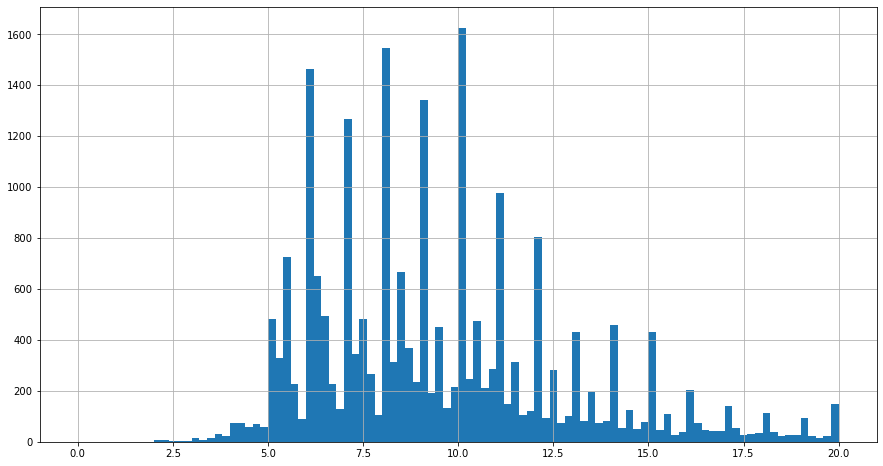

In [105]:
data['kitchen_area'].hist(bins=100, figsize=(15,8), grid=True, range=(0,20))

#### Цена (общая)

In [106]:
data['last_price'].describe()

count       23699.00
mean      6541548.77
std      10887013.27
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
max     763000000.00
Name: last_price, dtype: float64

Посмотрим на цену в тысячах рублей.

In [107]:
data['last_price_thousand']=(data['last_price']) / (1000)

In [108]:
data['last_price_thousand'].describe()

count    23699.00
mean      6541.55
std      10887.01
min         12.19
25%       3400.00
50%       4650.00
75%       6800.00
max     763000.00
Name: last_price_thousand, dtype: float64

Квартиры от 12 тыс.рублей до 763 миллиона рублей. Посмотрим на минимальное и максимальное значение. 

In [109]:
data.query('last_price_thousand==12.190000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
8793,7,12190.00,109.00,2019-03-20,2,2.75,25,32.00,25,False,False,False,40.50,0,Санкт-Петербург,36421.00,9176.00,1,805.00,0,NaN,8.00,0.29,0.37,111.83,2,3,2019,последний этаж,3,12.19


In [110]:
data.query('last_price_thousand==763000.000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
12971,19,763000000.00,400.00,2017-09-30,7,2.65,10,250.00,10,False,False,False,68.97,2,Санкт-Петербург,25108.00,3956.00,1,530.00,3,756.00,33.00,0.62,0.17,1907500.00,5,9,2017,последний этаж,3,763000.00


Если квартира стоимостью 763 млн. рублей площадью 400 кв.метров в 4 км. еще очень похожа на правдивые данные, то квартира ценой 12 тыс. рублей имеет 109 квадратных метров и расположена в 25-этажном доме на последнем этаже в Санкт-Петербурге в 9 км.от центра и в 800 м. от парка, при этом ее жилая площадь всего 32 квадратных метра и продана она была в 2019 году. Если застройка с высотой 25 этажей на расстоянии 9 км от центра еще может быть разрешена (центр СПб застраивать высотными зданиями нельзя), то цена в 12 тыс.рублей явно некорректная, скорее это 12 миллионов рублей (из-за небольшой жилой площади?). Эта запись очень похожа на ошибочную. Поэтому потребуется исследовать квартиры с наименьшей и наибольшей ценой, сделав сводную таблицу. 

In [111]:
data_pivot_last_price_thousand=data.pivot_table(index='last_price_thousand', values='total_area', aggfunc='count')
data_pivot_last_price_thousand.sort_values(by='total_area', ascending=False).head(10)

,total_area
last_price_thousand,
4500.00,342
3500.00,291
4300.00,260
4000.00,260
4200.00,259
3600.00,257
3300.00,244
3800.00,240
3200.00,238


Больше всего квартир по цене 4.5-3.2 млн.рублей

Отсортируем по цене, чтобы посмотреть максимальные и минимальные цены. 

In [112]:
data_pivot_last_price_thousand=data.pivot_table(index='last_price_thousand', values='total_area', aggfunc='count')
data_pivot_last_price_thousand.sort_values(by='last_price_thousand', ascending=False).head(10)

,total_area
last_price_thousand,
763000.00,1
420000.00,1
401300.00,1
330000.00,1
300000.00,1
289238.40,1
245000.00,1
240000.00,1
230000.00,1


In [113]:
data_pivot_last_price_thousand.sort_values(by='last_price_thousand', ascending=False).tail(10)

,total_area
last_price_thousand,
530.00,1
520.00,1
500.00,4
490.00,2
480.00,1
470.00,3
450.00,4
440.00,1
430.00,2


Видно, что цена в размере 12 тыс.рублей за квартиру - одно такое значение. Далее - от 430 тыс.рублей, что уже больше похоже на правдивые данные. 

В дальнейшем мы более подробно рассмотрим редкие и выбивающиеся значения, в том числе для цены. 

Посмотрим на гистограмму

<AxesSubplot:>

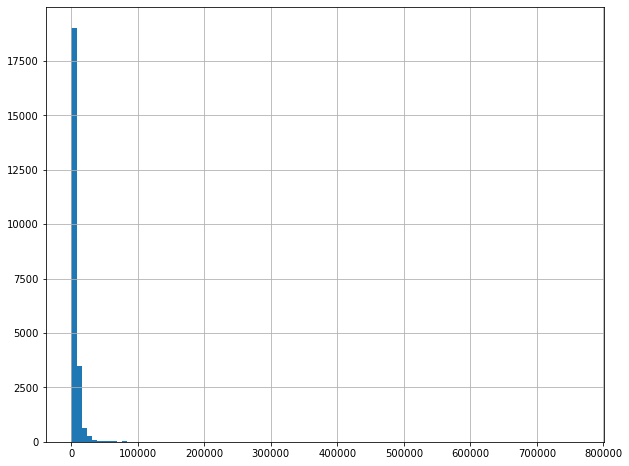

In [114]:
data['last_price_thousand'].hist(bins=100, figsize=(10,8))

В диапазоне от 0 до 40 млн рублей:

<AxesSubplot:>

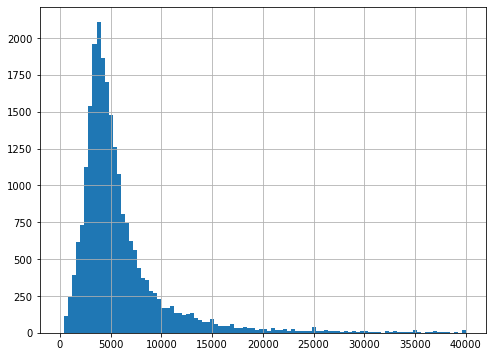

In [115]:
data['last_price_thousand'].hist(bins=100, figsize=(8,6), range=(0,40000))

Диапазон от 0 до 20 млн

<AxesSubplot:>

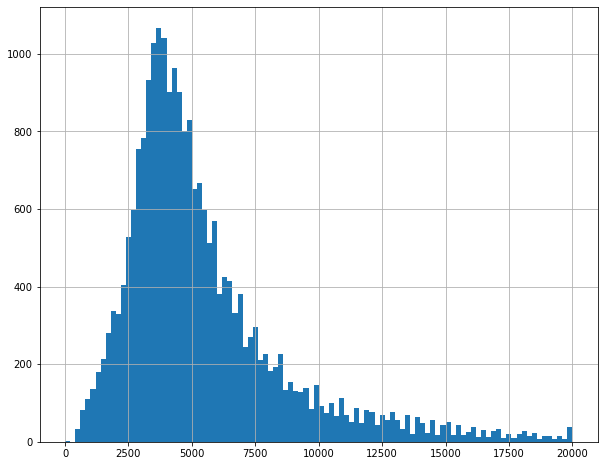

In [116]:
data['last_price_thousand'].hist(bins=100, figsize=(10,8), range=(0,20000))

Распределение без явных пиков и падений, как в случае с площадью квартиры, т.к. цена зависит от множества факторов и не подвержена ограничениям типовых планировок, как площадь. 

#### Цена за квадратный метр

In [117]:
data['square_meter_price'].describe().astype('int')

count      23699
mean       99421
std        50306
min          111
25%        76585
50%        95000
75%       114256
max      1907500
Name: square_meter_price, dtype: int32

<AxesSubplot:>

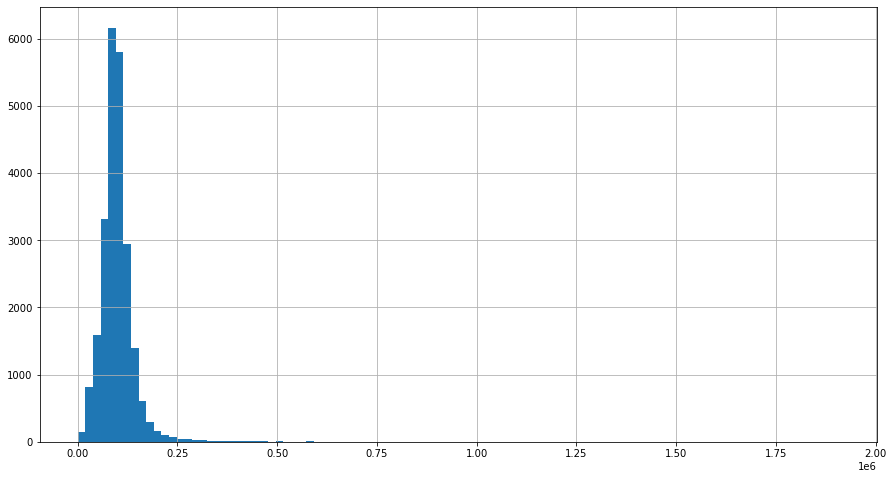

In [118]:
data['square_meter_price'].hist(bins=100, figsize=(15,8))

Посмотрим диапазон от 0 до 250 тысяч. 

<AxesSubplot:>

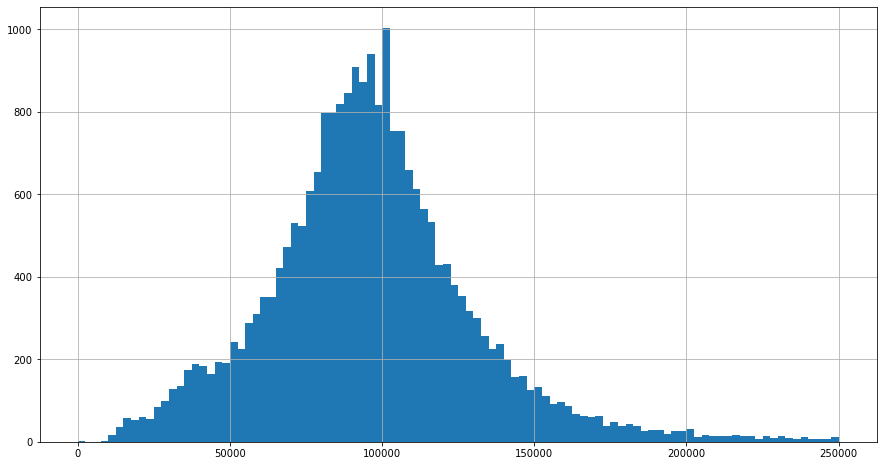

In [119]:
data['square_meter_price'].hist(bins=100, figsize=(15,8), range=(0, 250_000))

По виду распределение ожидаемо похоже на нормальное.

#### Число комнат

In [120]:
data['rooms'].describe()

count   23699.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

От 0 до 19 комнат, среднее количество комнат: 2

<AxesSubplot:>

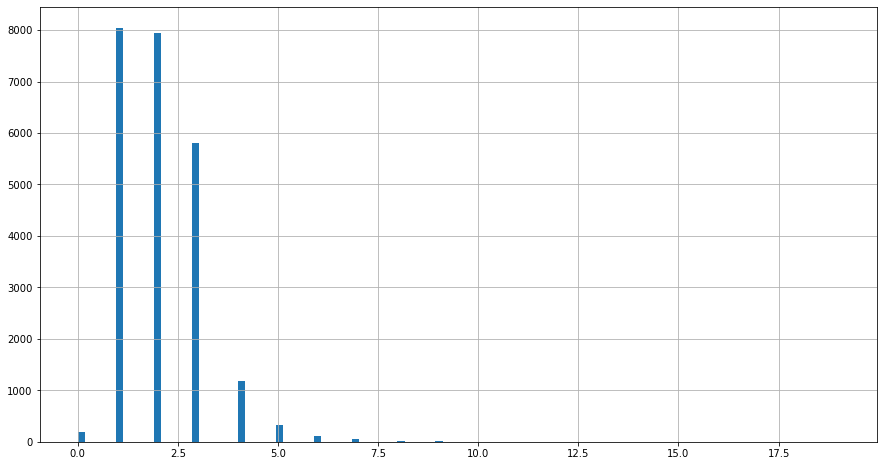

In [121]:
data['rooms'].hist(bins=100, figsize=(15,8))

#### Высота потолков

In [122]:
data['ceiling_height'].describe()

count   23699.00
mean        2.72
std         0.99
min         1.00
25%         2.60
50%         2.65
75%         2.70
max       100.00
Name: ceiling_height, dtype: float64

<AxesSubplot:>

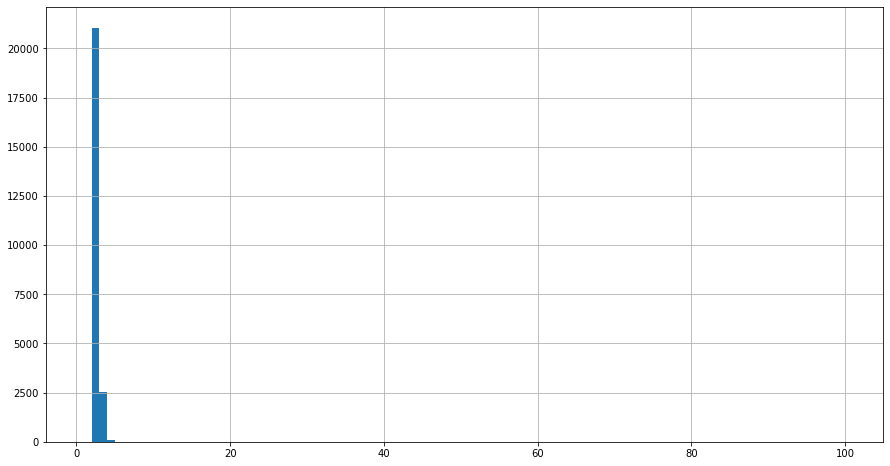

In [123]:
data['ceiling_height'].hist(bins=100, figsize=(15,8))

2.65 - стандарт высоты потолков. 

Высоту потолка в 100 метров рассмотрим, рассматривая редкие и выбивающиеся значения. 

### Время продажи квартиры

- Изучим время продажи квартиры. 
- Построим гистограмму. 
- Посчитаем среднее и медиану. 
- Опишем, сколько обычно занимает продажа. 
- Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [124]:
data['days_exposition'].describe()

count   20518.00
mean      180.89
std       219.73
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

<AxesSubplot:>

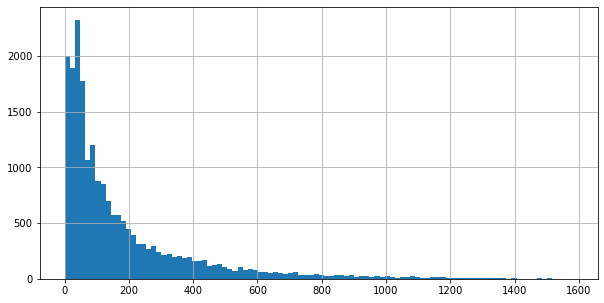

In [125]:
data['days_exposition'].hist(bins=100, figsize=(10,5))

Посмотрим диапазон от 0 до 365 дней.

<AxesSubplot:>

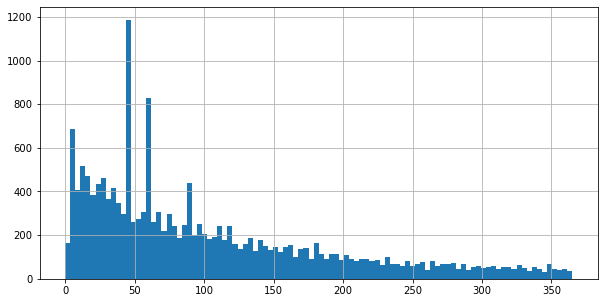

In [126]:
data['days_exposition'].hist(bins=100, figsize=(10,5), range=(0,365))

Есть некоторое количество выдающихся значений около 50 дней, 60 дней и т.д. Посмотрим распределение по сводной таблице.

In [127]:
data_pivot_days_exposition=data.pivot_table(index='days_exposition', values='total_area', aggfunc='count')
data_pivot_days_exposition.sort_values(by='total_area', ascending=False).head(10)

,total_area
days_exposition,
45.00,880
60.00,538
7.00,234
30.00,208
90.00,204
4.00,176
3.00,158
5.00,152
14.00,148


Наибольшее количество квартир продалось за 45 дней, 60 дней, 7, 30 и 90. Возможно, это периоды, на которые можно оплатить размещение объявления на сервисе, или время, по истечении которого объявление снимается автоматически?

In [128]:
data_pivot_days_exposition=data.pivot_table(index='days_exposition', values='total_area', aggfunc='count')
data_pivot_days_exposition.sort_values(by='days_exposition', ascending=True).head(10)

,total_area
days_exposition,
1.00,1
2.00,3
3.00,158
4.00,176
5.00,152
6.00,124
7.00,234
8.00,139
9.00,143


Что касается скорости продажи 1-2 дня, то за этот период продаются единицы квартир. Остальные - за срок хотя бы от 3 дней. 

Итак, посмотрим объявления со временем продажи более 3 лет. 

In [129]:
data_long_sales=data.query('days_exposition>1095').copy()
data_long_sales

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
353,4,5990000.00,43.50,2015-05-08,1,3.00,5,25.00,4,False,False,False,9.40,0,Санкт-Петербург,10527.00,10278.00,1,93.00,0,NaN,1292.00,0.57,0.22,137701.15,4,5,2015,другой этаж,2,5990.00
398,7,12789000.00,79.30,2014-12-09,2,3.00,8,43.10,5,False,False,False,17.60,0,Санкт-Петербург,39393.00,11096.00,1,537.00,0,NaN,1345.00,0.54,0.22,161273.64,1,12,2014,другой этаж,2,12789.00
437,12,3350000.00,37.00,2015-02-24,1,2.55,6,17.80,6,False,False,False,8.40,0,Петергоф,46151.00,34044.00,1,185.00,1,755.00,1273.00,0.48,0.23,90540.54,1,2,2015,последний этаж,3,3350.00
459,13,5200000.00,51.00,2016-03-02,2,2.55,9,32.00,5,False,False,False,6.00,0,Санкт-Петербург,48522.00,16360.00,0,NaN,0,NaN,1153.00,0.63,0.12,101960.78,2,3,2016,другой этаж,2,5200.00
512,8,6260000.00,43.30,2014-12-09,1,2.65,8,24.59,5,False,False,False,7.47,0,Санкт-Петербург,39946.00,10720.00,1,2102.00,3,303.00,1155.00,0.57,0.17,144572.75,1,12,2014,другой этаж,2,6260.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23055,8,3200000.00,33.00,2016-03-18,1,2.65,24,13.05,3,False,False,False,9.75,0,поселок Шушары,13461.00,19247.00,0,NaN,1,351.00,1130.00,0.40,0.30,96969.70,4,3,2016,другой этаж,2,3200.00
23212,9,7515162.00,58.80,2015-03-10,2,2.65,10,30.40,3,False,False,False,11.10,0,Санкт-Петербург,23604.00,5294.00,0,NaN,1,434.00,1239.00,0.52,0.19,127808.88,1,3,2015,другой этаж,2,7515.16
23248,5,4900000.00,80.00,2014-12-25,3,2.65,15,47.00,14,False,False,False,9.00,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,1187.00,0.59,0.11,61250.00,3,12,2014,другой этаж,2,4900.00
23318,6,5620020.00,82.30,2015-03-10,3,2.70,21,45.60,12,False,False,False,15.70,0,Санкт-Петербург,21793.00,17121.00,0,NaN,1,31.00,1200.00,0.55,0.19,68287.00,1,3,2015,другой этаж,2,5620.02


In [130]:
data_long_sales['days_exposition'].describe()

count    166.00
mean    1247.43
std      117.16
min     1099.00
25%     1154.25
50%     1213.50
75%     1330.25
max     1580.00
Name: days_exposition, dtype: float64

166 квартир продавались очень долго. 

Посмотрим на общую цену квартиры. 

In [131]:
data_long_sales['last_price'].mean()

9223560.61445783

Посмотрим на среднюю цену квадратного метра для этих долго продающихся квартир. 

In [132]:
data_long_sales['square_meter_price'].mean()

110058.24702032938

In [133]:
data_long_sales['locality_name'].value_counts()

Санкт-Петербург                   126
Пушкин                              4
Петергоф                            3
Коммунар                            3
Павловск                            2
Всеволожск                          2
Сертолово                           2
поселок Мурино                      2
Кронштадт                           2
Отрадное                            1
Колпино                             1
Сестрорецк                          1
Лодейное Поле                       1
деревня Новое Девяткино             1
Ломоносов                           1
поселок городского типа Вырица      1
Кудрово                             1
деревня Калитино                    1
Красное Село                        1
поселок Лисий Нос                   1
деревня Кудрово                     1
поселок Молодежное                  1
поселок Рябово                      1
поселок Парголово                   1
Шлиссельбург                        1
поселок Тельмана                    1
Кириши      

Посмотрим на общую площадь. 

In [134]:
data_long_sales['total_area'].mean()

81.38060240963856

Вывод: 
- Более долго продаются квартиры бОльшей площади с чуть больше среднего ценой квадратного метра, с общей ценой квартиры выше среднего. 

Посмотрим на квартиры, продававшиеся быстро. 

<AxesSubplot:>

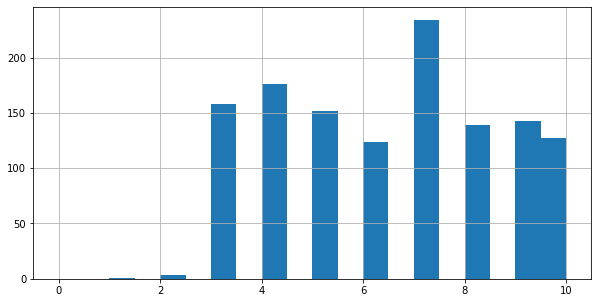

In [135]:
data['days_exposition'].hist(bins=20, figsize=(10,5), range=(0,10))

In [136]:
data_fast_sales=data.query('days_exposition<10')
data_fast_sales

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
11,9,3300000.00,44.00,2018-08-27,2,2.65,5,31.00,4,False,False,False,6.00,1,Ломоносов,48252.00,51677.00,0,NaN,0,NaN,7.00,0.70,0.14,75000.00,0,8,2018,другой этаж,2,3300.00
53,7,4300000.00,39.10,2017-11-10,1,2.65,25,15.40,13,False,False,False,15.50,2,поселок Парголово,52611.00,18783.00,0,NaN,0,NaN,6.00,0.39,0.40,109974.42,4,11,2017,другой этаж,2,4300.00
62,0,4800000.00,78.60,2017-09-17,3,2.80,9,48.80,5,False,False,False,11.90,2,Сертолово,NaN,NaN,0,NaN,0,NaN,5.00,0.62,0.15,61068.70,6,9,2017,другой этаж,2,4800.00
94,3,3500000.00,29.50,2019-04-26,1,2.50,5,15.60,2,False,False,False,5.50,1,Санкт-Петербург,12921.00,7303.00,0,NaN,0,NaN,4.00,0.53,0.19,118644.07,4,4,2019,другой этаж,2,3500.00
100,16,3800000.00,38.60,2018-02-22,1,2.65,9,18.00,6,False,False,False,8.40,2,Санкт-Петербург,36450.00,13364.00,0,NaN,0,NaN,8.00,0.47,0.22,98445.60,3,2,2018,другой этаж,2,3800.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23513,12,8300000.00,62.60,2017-02-15,2,2.70,16,32.90,8,False,False,False,11.30,2,Санкт-Петербург,29077.00,10858.00,0,NaN,0,NaN,7.00,0.53,0.18,132587.86,2,2,2017,другой этаж,2,8300.00
23596,10,3500000.00,43.50,2017-12-05,2,2.50,9,27.00,6,False,False,False,6.20,0,Санкт-Петербург,49094.00,16671.00,0,NaN,0,NaN,6.00,0.62,0.14,80459.77,1,12,2017,другой этаж,2,3500.00
23606,0,2850000.00,68.00,2018-07-29,1,3.00,5,41.00,3,False,False,False,10.00,0,Санкт-Петербург,38473.00,7740.00,2,560.00,3,327.00,4.00,0.60,0.15,41911.76,6,7,2018,другой этаж,2,2850.00
23647,9,5700000.00,45.60,2019-01-09,1,2.75,16,18.70,6,False,False,False,17.60,0,Санкт-Петербург,10934.00,12551.00,0,NaN,0,NaN,8.00,0.41,0.39,125000.00,2,1,2019,другой этаж,2,5700.00


1130 квартир продалось за период менее 10 дней.

Посмотрим на среднюю цену квартиры. 

In [137]:
data_fast_sales['last_price'].mean()

5395332.83539823

Посмотрим на среднюю цену квадратного метра. 

In [138]:
data_fast_sales['square_meter_price'].mean()

99513.92688694515

Посмотрим на общую площадь. 

In [139]:
data_fast_sales['total_area'].mean()

52.80733628318588

Вывод: 
- средняя цена квадратного метра у быстро продающихся квартир меньше, чем у долго продающихся, общая цена тоже меньше, как и общая площадь. 

Посмотрим на местоположение. 

In [140]:
data_fast_sales['locality_name'].value_counts().head(10)

Санкт-Петербург      803
поселок Мурино        34
поселок Парголово     21
Колпино               20
Пушкин                19
поселок Шушары        17
деревня Кудрово       17
Гатчина               16
Всеволожск            12
Кудрово                9
Name: locality_name, dtype: int64

Мы видим, что среди быстро продающихся квартир гораздо больше других локаций, чем среди долго продающихся. Квартиры в Ленинградской области "подвисают" в продаже относительно меньше, чем по С-Петербурге. 

Посмотрим взаимосвязь скорости продажи квартиры и ее местоположения. 

Дольше всего продаются квартиры, находящиеся по направлению трассы С-Петербург - Москва, в районе Лен.области с сомнительной экологией. 

In [141]:
locality_days_exposition_pivot=data.pivot_table(index='locality_name', values=['days_exposition', 'total_area'], aggfunc='median')
locality_days_exposition_pivot.sort_values(by='days_exposition', ascending=False).head(10)

,days_exposition,total_area
locality_name,,
поселок Севастьяново,1069.00,62.00
поселок Молодежное,1043.00,51.40
деревня Рабитицы,1007.00,55.40
поселок Коробицыно,750.00,58.45
поселок Любань,654.00,50.00
деревня Большая Пустомержа,627.00,53.50
деревня Зимитицы,610.00,58.00
поселок Рябово,574.50,72.25
деревня Мины,540.00,48.00


Быстрее всего продающиеся квартиры находятся в Лен.области на карельском перешейке

In [142]:
locality_days_exposition_pivot.sort_values(by='days_exposition', ascending=True).head(10)

,days_exposition,total_area
locality_name,,
поселок Володарское,5.00,47.20
поселок Заводской,5.00,29.20
садовое товарищество Садко,7.00,56.00
коттеджный поселок Счастье,7.00,72.00
деревня Яльгелево,7.00,44.90
село Шум,9.00,59.00
поселок Семиозерье,9.00,56.00
деревня Малая Романовка,9.00,66.80
поселок Новогорелово,10.00,40.85


In [143]:
print(
    'В Санкт-Петербурге квартиры продаются в среднем за {} дня'.format(
        round(
            data.query('locality_name=="Санкт-Петербург"')['days_exposition'].mean()
        )))

В Санкт-Петербурге квартиры продаются в среднем за 183 дня


Посмотрим взаимосвязь скорости продажи квартиры и удаленности ее от центра Санкт-Петербурга (в первом приближении для всех квартир, затем - для Санкт-Петербурга). 

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='days_exposition'>

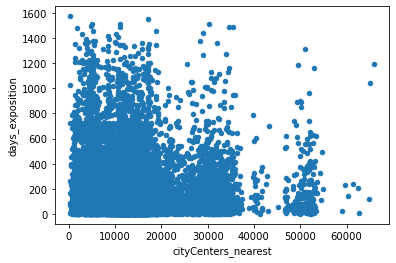

In [144]:
data.plot(x='cityCenters_nearest', y='days_exposition', kind='scatter')

In [145]:
data['cityCenters_nearest'].corr(data['days_exposition'])

-0.06060691579222223

Коэффициент корреляции практически нулевой. 

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='days_exposition'>

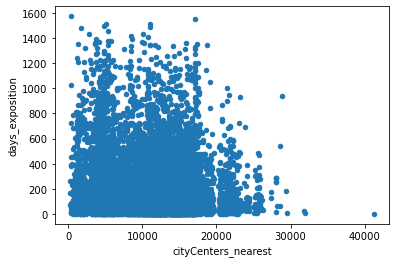

In [146]:
data.query('locality_name=="Санкт-Петербург"').plot(x='cityCenters_nearest', y='days_exposition', kind='scatter')

In [147]:
data.query('locality_name=="Санкт-Петербург"')['cityCenters_nearest'].corr(data['days_exposition'])

-0.13842712425324036

Коэффициент корреляции также очень мал (отрицателен).

Посмотрим взаимосвязь скорости продажи квартиры и цены за квадратный метр. 

<AxesSubplot:xlabel='square_meter_price', ylabel='days_exposition'>

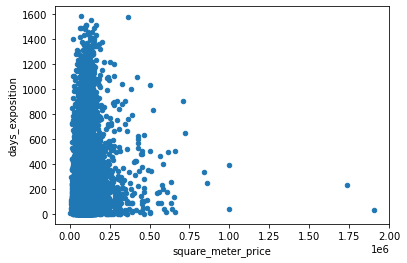

In [148]:
data.plot(x='square_meter_price', y='days_exposition', kind='scatter')

Визуально можем сделать вывод о том, что при одной и той же цене за квадратный метр квартиры продаются с разной скоростью. Посмотрим на коэффициент корреляции. 

In [149]:
data['square_meter_price'].corr(data['days_exposition'])

0.04812006139298614

Он также очень далек от 1, что означает, что зависимости как таковой нет, несмотря на то, что (в среднем) мы увидели, что быстрее продаются небольшие квартиры с недорогим квадратным метром. 

Возможно, правда, что имеет место нелинейная зависимость, близость к которой коэффициент корреляции не отражает. 

Посмотрим взаимосвязь скорости продажи квартиры и ее площади. 

<AxesSubplot:xlabel='total_area', ylabel='days_exposition'>

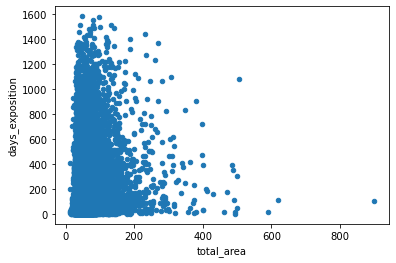

In [150]:
data.plot(x='total_area', y='days_exposition', kind='scatter')

In [151]:
data['total_area'].corr(data['days_exposition'])

0.14967517208715717

Коэфициент корреляции также очень далек от 1, что означает, что линейной зависимости как таковой нет, несмотря на то, как и прежде, (в среднем) быстрее продаются небольшие квартиры с недорогим квадратным метром.

Посмотрим, в каком году квартиры продавались быстрее всего. 

In [152]:
data.pivot_table(index='year_exposition', values='days_exposition', aggfunc='mean').sort_values(by='days_exposition', ascending=False)

,days_exposition
year_exposition,
2014,910.98
2015,648.04
2016,320.75
2017,158.96
2018,94.34
2019,30.93


По данным этой сводной таблицы квартиры год от года продаются всё быстрее и быстрее, и за шесть лет скорость продажи квартир увеличилась в 30 раз. Возможно, это связано с тем, что ранее к сервису обращались только в том случае, если недвижимость было не продать другими способами, и сервис был развит мало (к тому же мы ранее видели, что статистика за 2014 год собирается только с ноября, а в 2019 году - только по май). Посмотрим, сколько объявлений (как с указанным количеством дней размещения, так и без этих данных) было на сервисе в каком году. 

In [153]:
days_pivot=data.pivot_table(index='year_exposition', values=['month_exposition', 'days_exposition'], aggfunc='count').sort_values(by='year_exposition', ascending=False)
days_pivot.columns=['with_days_exposition_data', 'without_days_exposition_data']
days_pivot

,with_days_exposition_data,without_days_exposition_data
year_exposition,,
2019,1083,2879
2018,7560,8519
2017,7919,8190
2016,2716,2783
2015,1121,1191
2014,119,137


###   Вывод: 
- судя по средним данным, быстрее продаются меньшие по площади, более дешевые квартиры (как по общей цене, так и по цене за квадратный метр), 
- прямой линейной зависимости между этими факторами (по-отдельности) и скоростью продажи квартиры не обнаружено. 

## Редкие и выбивающиеся значения

Когда мы рассматривали цену квартиры, мы нашли квартиру за 12 тысяч рублей с неподобающей этой цене площадью и расположением в Санкт-Петербурге. Очевидно, что данная запись некорректна, и этот выброс следует удалить. 

In [154]:
data=data.query('last_price_thousand>12.2')
len(data)

23698

Данная строка удалена, записей стало на 1 меньше. 

Изучая данные о высоте потолков, мы нашли потолок высотой 100 метров. Посмотрим, какие еще есть потолки. 

In [155]:
data_pivot_ceiling_height=data.pivot_table(index='ceiling_height', values='total_area', aggfunc='count')
data_pivot_ceiling_height.sort_values(by='ceiling_height', ascending=False).head(10)

,total_area
ceiling_height,
100.00,1
32.00,2
27.50,1
27.00,8
26.00,1
25.00,7
24.00,1
22.60,1
20.00,1


Потолок в 100 метров есть только в одной квартире. 100 метров - это высота 30-этажного здания. 

In [156]:
data.query('ceiling_height==100.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
22869,0,15000000.00,25.00,2018-07-25,1,100.00,5,14.00,5,True,False,False,11.00,5,Санкт-Петербург,34963.00,8283.00,1,223.00,3,30.00,19.00,0.56,0.44,600000.00,2,7,2018,последний этаж,3,15000.00


Апартаменты в СПб общей площадью 25 кв на 5 этаже 5-этажного дома в 8 км от центра города возле прудов и парка по цене 600 тыс.рублей за квадратный метр и общей ценой 15 млн. рублей. Всё может быть кроме высоты потолков в 100 метров. Близко к центру города даже зданий такой высоты нет. 

Удалим строки с высотой потолка более 20 метров.

In [157]:
data = data.loc[(data['ceiling_height']<20)]

In [158]:
len(data)

23675

### Факторы, больше всего влияющие на стоимость квартиры

Изучим, зависит ли цена 
- от площади, 
- числа комнат, 
- удалённости от центра, 
- от того, на каком этаже расположена квартира: первом, последнем или другом, 
- от даты размещения: дня недели, месяца и года.

#### Взаимосвязь общей цены и общей площади квартиры. 

<AxesSubplot:xlabel='total_area', ylabel='last_price_thousand'>

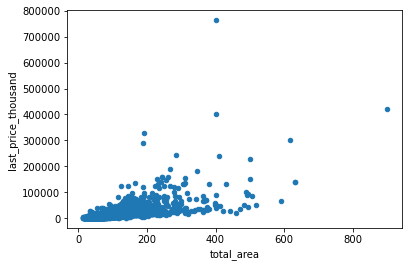

In [159]:
data.plot(x='total_area', y='last_price_thousand', kind='scatter')

Квартиры разного метража продаются по схожей цене. 

In [160]:
data['total_area'].corr(data['last_price_thousand'])

0.653837549056574

Коэффициент корреляции гораздо больше нуля, чем в предыдущих случаях, но всё же ближе к 0.5, чем к 1. Это средняя линейная зависимость. 

####  Взаимосвязь цены квадратного метра и общей площади квартиры. 

<AxesSubplot:xlabel='total_area', ylabel='square_meter_price'>

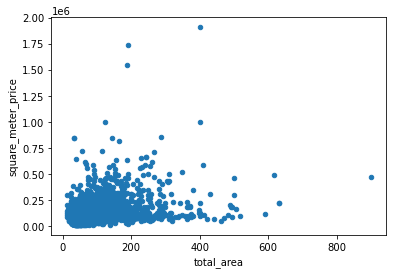

In [161]:
data.plot(x='total_area', y='square_meter_price', kind='scatter')

In [162]:
data['total_area'].corr(data['square_meter_price'])

0.30333687524166925

Линейная зависимость слабая. 

#### Взаимосвязь общей цены и числа комнат

<AxesSubplot:xlabel='rooms', ylabel='last_price_thousand'>

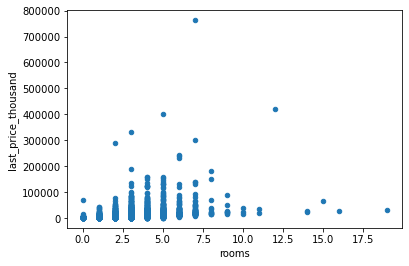

In [163]:
data.plot(x='rooms', y='last_price_thousand', kind='scatter')

In [164]:
data['last_price'].corr(data['rooms'])

0.36348307715760264

Линейная зависимость незначительная, слабая. Квартиры с одним и тем же количеством комнат продаются по разной цене. 

#### Взаимосвязь цены квадратного метра и числа комнат.

<AxesSubplot:xlabel='rooms', ylabel='square_meter_price'>

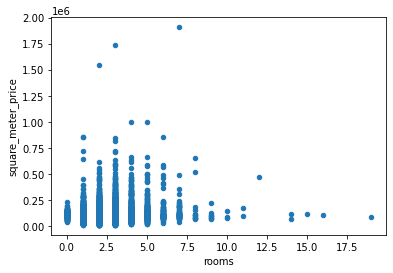

In [165]:
data.plot(x='rooms', y='square_meter_price', kind='scatter')

In [166]:
data['square_meter_price'].corr(data['rooms'])

0.05620516832834238

In [167]:
data_pivot_square_meter_price_rooms=data.pivot_table(index='rooms', values='square_meter_price', aggfunc='mean')
data_pivot_square_meter_price_rooms.sort_values(by='rooms', ascending=True)

,square_meter_price
rooms,
0,108454.51
1,100753.96
2,95522.29
3,97170.79
4,110390.57
5,126750.34
6,140718.81
7,163569.92
8,184651.17


Посмотрим на количество квартир в каждой группе количества комнат. С количеством комнат больше 7 - единицы квартир. 

In [168]:
data_pivot_square_meter_price_rooms=data.pivot_table(index='rooms', values='square_meter_price', aggfunc='count')
data_pivot_square_meter_price_rooms.sort_values(by='rooms', ascending=True)

,square_meter_price
rooms,
0,196
1,8041
2,7928
3,5810
4,1179
5,326
6,105
7,59
8,12


<AxesSubplot:xlabel='rooms'>

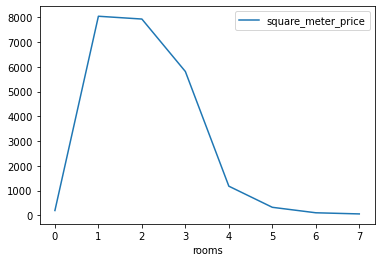

In [169]:
data_pivot_square_meter_price_rooms.query('rooms<=7').plot()

Прямая зависимость отсутствует, но после количества комнат 2 шт., средняя цена квадратного метра начинает падать. 

5. Взаимосвязь общей цены и удаленности от центра. 

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price_thousand'>

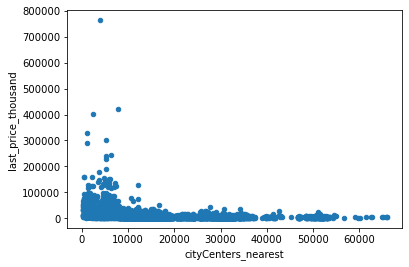

In [170]:
data.plot(x='cityCenters_nearest', y='last_price_thousand', kind='scatter')

Квартиры на одинаковом расстоянии от центра продаются по разной цене. 

In [171]:
data['last_price'].corr(data['cityCenters_nearest'])

-0.20619824048461477

Чем больше расстояние от центра, тем меньше цена, но зависимость очень слабая. 

6. Взаимосвязь цены квадратного метра и удаленности от центра. 

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='square_meter_price'>

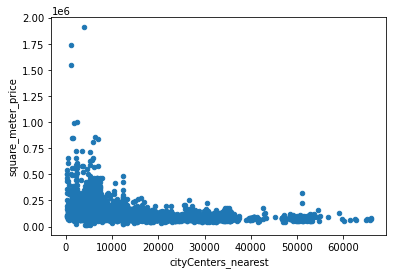

In [172]:
data.plot(x='cityCenters_nearest', y='square_meter_price', kind='scatter')

Квартиры на разном удалении от центра города могут иметь одну и ту же цену квадратного метра. 

In [173]:
data['square_meter_price'].corr(data['cityCenters_nearest'])

-0.3171438792774142

В целом, чем больше расстояние от центра, тем меньше цена квадратного метра, но зависимость очень слабая.

#### Зависимость общей цены от этажа (первый, последний и т.д.)

In [174]:
data_pivot_last_price_thousand_floor_category=data.pivot_table(index='floor_category', values='last_price_thousand', aggfunc='median')
data_pivot_last_price_thousand_floor_category.sort_values(by='floor_category', ascending=True)

,last_price_thousand
floor_category,
другой этаж,4850.00
первый этаж,3900.00
последний этаж,4300.00


#### Зависимость цены квадратного метра от этажа (первый, последний и т.д.)

In [175]:
data_pivot_square_meter_price_floor_category=data.pivot_table(index='floor_category', values='square_meter_price', aggfunc='median')
data_pivot_square_meter_price_floor_category.sort_values(by='floor_category', ascending=True)

,square_meter_price
floor_category,
другой этаж,98305.08
первый этаж,81296.30
последний этаж,87671.23


Тот же вывод в отношении цены квадратного метра: он дороже на "другом" этаже, чем на первом или последнем. 

#### Зависимость общей цены от даты размещения (день недели, месяц, год)

In [176]:
data_pivot_last_price_weekday=data.pivot_table(index='weekday_exposition', values='last_price_thousand', aggfunc='median')
data_pivot_last_price_weekday.sort_values(by='last_price_thousand', ascending=False)

,last_price_thousand
weekday_exposition,
1,4725.00
2,4700.00
0,4650.00
3,4650.00
4,4590.00
5,4555.00
6,4550.00


Средняя цена примерно одинакова в любой день недели, и коэффициент корреляции отсутствует. 

In [177]:
data['weekday_exposition'].corr(data['last_price_thousand'])

0.0015233879533670487

То же касается и цены квадратного метра. 

In [178]:
data_pivot_square_meter_price_weekday=data.pivot_table(index='weekday_exposition', values='square_meter_price', aggfunc='median')
data_pivot_square_meter_price_weekday.sort_values(by='weekday_exposition', ascending=True)

,square_meter_price
weekday_exposition,
0,94703.96
1,95643.13
2,95462.17
3,95152.59
4,94625.00
5,93545.72
6,94533.47


In [179]:
data_pivot_last_price_month=data.pivot_table(index='month_exposition', values='last_price_thousand', aggfunc='median')
data_pivot_last_price_month.sort_values(by='last_price_thousand', ascending=False)

,last_price_thousand
month_exposition,
4,4800.00
9,4700.00
11,4700.00
12,4700.00
3,4685.00
2,4650.00
7,4650.00
1,4600.00
10,4572.50


In [180]:
data['month_exposition'].corr(data['last_price_thousand'])

0.0027904630797668055

In [181]:
data_pivot_square_meter_price_month=data.pivot_table(index='month_exposition', values='square_meter_price', aggfunc='median')
data_pivot_square_meter_price_month.sort_values(by='square_meter_price', ascending=False)

,square_meter_price
month_exposition,
4,96428.57
8,96052.63
11,95606.62
9,95599.69
3,95516.57
1,95209.58
2,95000.00
7,95000.00
12,94280.08


Зависимость цены от года размещения объявления также отсутствует. 

In [182]:
data_pivot_last_price_year=data.pivot_table(index='year_exposition', values='last_price_thousand', aggfunc='median')
data_pivot_last_price_year.sort_values(by='last_price_thousand', ascending=False)

,last_price_thousand
year_exposition,
2014,7700.00
2015,5350.00
2019,5050.00
2016,4550.00
2018,4550.00
2017,4500.00


In [183]:
data['last_price_thousand'].corr(data['year_exposition'])

-0.04307230591906564

In [184]:
data_pivot_square_meter_price_year=data.pivot_table(index='year_exposition', values='square_meter_price', aggfunc='median')
data_pivot_square_meter_price_year.sort_values(by='square_meter_price', ascending=False)

,square_meter_price
year_exposition,
2014,107000.00
2019,103550.30
2018,95691.72
2015,93426.07
2017,92565.09
2016,91743.12


In [185]:
data['square_meter_price'].corr(data['year_exposition'])

0.008571201192138877

Цена квадратного метра была самой высокой в 2014 и 2019 году, а в 2016 - наименьшей, как иллюстрация кризиса на рынке недвижимости в СПб в 2016 году. 

<AxesSubplot:xlabel='year_exposition'>

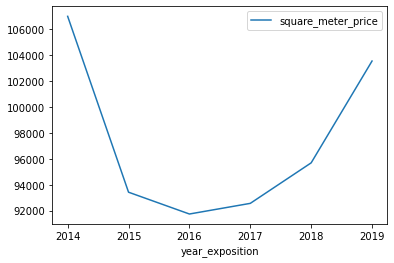

In [186]:
data_pivot_square_meter_price_year.plot()

#### Зависимость между ценой и ценой квадратного метра: 

In [187]:
data['last_price'].corr(data['square_meter_price'])

0.7378212492022511

Зависимость между общей ценой и ценой квадратного метра значительная, она прямая. Чем выше цена, тем выше и стоимость одного квадратного метра в квартире. В более дорогих квартирах даже один метр площади дороже. 

Нашлись факторы, имеющие влияние на цену (цену квадратного метра), но влияние каждого фактора по-отдельности незначительное.

In [188]:
data_for_plotting_scatter=data.copy()
data_for_plotting_scatter=data_for_plotting_scatter.drop(
    ['total_images', 'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 
     'living_area', 'floor', 'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony', 
     'locality_name', 'airports_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 
     'ponds_nearest', 'days_exposition', 'living_area_ratio', 'kitchen_area_ratio', 
     'weekday_exposition', 'month_exposition', 'year_exposition', 'floor_category', 
     'floor_category_id', 'cityCenters_nearest'], axis=1
)
data_for_plotting_scatter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23675 entries, 0 to 23698
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   last_price           23675 non-null  float64
 1   total_area           23675 non-null  float64
 2   square_meter_price   23675 non-null  float64
 3   last_price_thousand  23675 non-null  float64
dtypes: float64(4)
memory usage: 924.8 KB


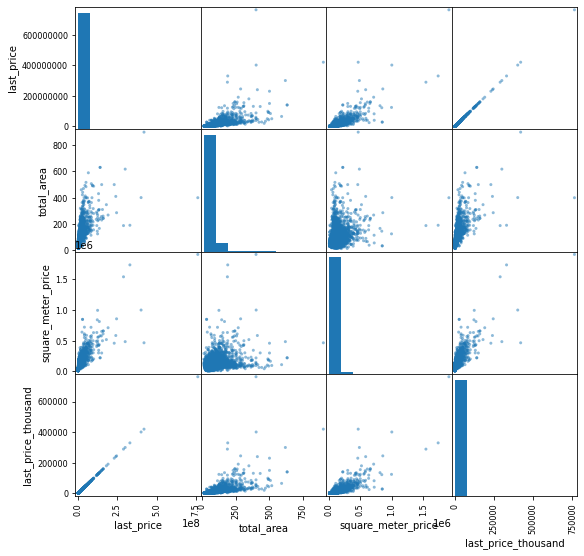

In [189]:
pd.plotting.scatter_matrix(data_for_plotting_scatter, figsize=(9, 9)) 
print()

### Топ-10 населённых пунктов с наибольшим числом объявлений

Рассмотрим 10 населённых пунктов с наибольшим числом объявлений, получим названия этих населенных пунктов в виде списка. 

In [190]:
locality_pivot=data.pivot_table(index='locality_name', values='total_area', aggfunc='count')
locality_pivot.columns=['sales_quantity']
locality_pivot_top=locality_pivot.sort_values(by='sales_quantity', ascending=False).head(10)
locality_pivot_top

,sales_quantity
locality_name,
Санкт-Петербург,15756
поселок Мурино,554
поселок Шушары,440
Всеволожск,398
Пушкин,369
Колпино,338
поселок Парголово,327
Гатчина,306
деревня Кудрово,299


In [191]:
data['last_price'].corr(data['square_meter_price'])

0.7378212492022511

In [192]:
top_ten_localities_list=locality_pivot_top.index.unique().tolist()
top_ten_localities_list

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

Выделим все записи из data, населенные пункты которых содержатся в найденном нами "Топ-10"

In [193]:
data_top_ten_localities=data.query('locality_name in @top_ten_localities_list')
display(data_top_ten_localities.shape)
data_top_ten_localities.head(5)

(19024, 31)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,NaN,0.47,0.23,120370.37,3,3,2019,другой этаж,2,13000.00
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.00,18603.00,0,NaN,0,NaN,81.00,0.46,0.27,82920.79,1,12,2018,первый этаж,1,3350.00
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558.00,0.61,0.15,92785.71,3,8,2015,другой этаж,2,5196.00
3,0,64900000.00,159.00,2015-07-24,3,2.65,14,90.29,9,False,False,False,27.41,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424.00,0.57,0.17,408176.10,4,7,2015,другой этаж,2,64900.00
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121.00,0.32,0.41,100000.00,1,6,2018,другой этаж,2,10000.00


In [194]:
print('Для Топ-10 населенных пунктов это {} объявлений.'.format(len(data_top_ten_localities)))

Для Топ-10 населенных пунктов это 19024 объявлений.


Определим среднюю цену квадратного метра в этих населенных пунктах. 

In [195]:
data_top_ten_localities_pivot=data_top_ten_localities.pivot_table(index='locality_name', values='square_meter_price', aggfunc='mean')
data_top_ten_localities_pivot

,square_meter_price
locality_name,
Всеволожск,68654.47
Выборг,58141.91
Гатчина,68757.68
Колпино,75424.58
Пушкин,103125.82
Санкт-Петербург,114770.62
деревня Кудрово,92473.55
поселок Мурино,85656.21
поселок Парголово,90175.91


Населенный пункт из Топ-10 с самой высокой средней стоимостью квадратного метра:

In [196]:
data_top_ten_localities_pivot.query('square_meter_price==square_meter_price.max()')

,square_meter_price
locality_name,
Санкт-Петербург,114770.62


Населенный пункт из Топ-10 с самой низкой средней стоимостью квадратного метра:

In [197]:
data_top_ten_localities_pivot.query('square_meter_price==square_meter_price.min()')

,square_meter_price
locality_name,
Выборг,58141.91


Выборг и Гатчина дальше всех от Санкт-Петербурга. Все остальные населенные пункты - фактически его пригороды. 

### Предложения квартир (расстояние до центра)

Выделим по локации Санкт-Петербург. Сформируем датафрейм spb_data и будем работать с ним. 

In [198]:
spb_data=data[data['locality_name']=='Санкт-Петербург'].copy()
spb_data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,NaN,0.47,0.23,120370.37,3,3,2019,другой этаж,2,13000.00
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558.00,0.61,0.15,92785.71,3,8,2015,другой этаж,2,5196.00
3,0,64900000.00,159.00,2015-07-24,3,2.65,14,90.29,9,False,False,False,27.41,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424.00,0.57,0.17,408176.10,4,7,2015,другой этаж,2,64900.00
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121.00,0.32,0.41,100000.00,1,6,2018,другой этаж,2,10000.00
7,5,7915000.00,71.60,2019-04-18,2,2.65,24,40.66,22,False,False,False,18.90,2,Санкт-Петербург,23982.00,11634.00,0,NaN,0,NaN,NaN,0.57,0.26,110544.69,3,4,2019,другой этаж,2,7915.00


In [199]:
spb_data['center_km']=(spb_data['cityCenters_nearest'])/1000
spb_data['center_km']=round(spb_data['center_km'], 0).astype('int')
spb_data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,kitchen_area_ratio,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_id,last_price_thousand,center_km
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,NaN,0.47,0.23,120370.37,3,3,2019,другой этаж,2,13000.00,16
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558.00,0.61,0.15,92785.71,3,8,2015,другой этаж,2,5196.00,14
3,0,64900000.00,159.00,2015-07-24,3,2.65,14,90.29,9,False,False,False,27.41,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424.00,0.57,0.17,408176.10,4,7,2015,другой этаж,2,64900.00,7
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121.00,0.32,0.41,100000.00,1,6,2018,другой этаж,2,10000.00,8
7,5,7915000.00,71.60,2019-04-18,2,2.65,24,40.66,22,False,False,False,18.90,2,Санкт-Петербург,23982.00,11634.00,0,NaN,0,NaN,NaN,0.57,0.26,110544.69,3,4,2019,другой этаж,2,7915.00,12


Выясним, какая область входит в центр: посчитаем среднюю цену для каждого километра и построим график, показывающий, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [200]:
spb_data_pivot_table=spb_data.pivot_table(index='center_km', values='square_meter_price', aggfunc='mean')
spb_data_pivot_table

,square_meter_price
center_km,
0,245833.53
1,176640.65
2,157944.35
3,121138.76
4,133071.55
5,140324.47
6,151012.19
7,156176.88
8,124786.50


<AxesSubplot:xlabel='center_km'>

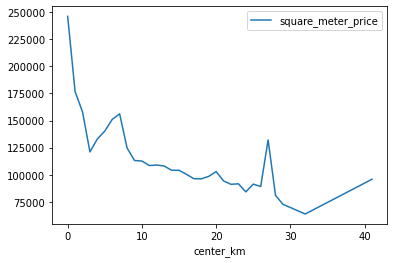

In [201]:
spb_data_pivot_table.plot()

После 7 км от центра города происходит резкое падение цены квадратного метра. Примем расстояние от центра города менее 7 км как центральную зону. 

### Квартиры в центре

Выделим сегмент квартир в центре. 

In [202]:
spb_center_data=data.loc[data['cityCenters_nearest']<7000].copy()
spb_center_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3319 entries, 3 to 23694
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          3319 non-null   int64         
 1   last_price            3319 non-null   float64       
 2   total_area            3319 non-null   float64       
 3   first_day_exposition  3319 non-null   datetime64[ns]
 4   rooms                 3319 non-null   int64         
 5   ceiling_height        3319 non-null   float64       
 6   floors_total          3319 non-null   int32         
 7   living_area           3319 non-null   float64       
 8   floor                 3319 non-null   int64         
 9   is_apartment          3319 non-null   bool          
 10  studio                3319 non-null   bool          
 11  open_plan             3319 non-null   bool          
 12  kitchen_area          3319 non-null   float64       
 13  balcony          

Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. 

In [203]:
spb_center_data['total_area'].describe()

count   3319.00
mean      94.16
std       60.11
min       12.00
25%       57.80
50%       80.00
75%      110.60
max      631.20
Name: total_area, dtype: float64

Средняя общая площадь квартир в центре больше, чем по городу. 

In [204]:
spb_center_data['square_meter_price'].describe()

count      3319.00
mean     144617.75
std       93731.08
min       15345.27
25%       99407.67
50%      123333.33
75%      155848.15
max     1907500.00
Name: square_meter_price, dtype: float64

In [205]:
spb_center_data['last_price_thousand'].describe()

count     3319.00
mean     14945.79
std      24622.02
min       1600.00
25%       6700.00
50%       9300.00
75%      14500.00
max     763000.00
Name: last_price_thousand, dtype: float64

Выше как средняя общая цена, так и цена квадратного метра. 

In [206]:
spb_center_data['rooms'].describe()

count   3319.00
mean       2.86
std        1.47
min        0.00
25%        2.00
50%        3.00
75%        4.00
max       19.00
Name: rooms, dtype: float64

In [207]:
spb_center_data['ceiling_height'].describe()

count   3319.00
mean       2.95
std        0.38
min        2.40
25%        2.65
50%        2.84
75%        3.16
max        6.00
Name: ceiling_height, dtype: float64

Комнат в среднем 3, а не 2. И средняя высота потолков выше. 

Выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

#### Взаимосвязь числа комнат и цены квадратного метра. 

In [208]:
spb_center_data['square_meter_price'].corr(spb_center_data['rooms'])

-0.010084743525481703

In [209]:
rooms_spb_center_pivot=spb_center_data.pivot_table(index='rooms', values='square_meter_price', aggfunc='mean')
rooms_spb_center_pivot.sort_values(by='rooms', ascending=True)

,square_meter_price
rooms,
0,146371.95
1,154816.07
2,142562.51
3,142801.16
4,137669.94
5,145011.14
6,153676.49
7,167223.47
8,192737.02


<AxesSubplot:xlabel='rooms'>

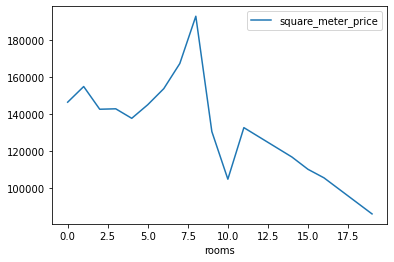

In [210]:
rooms_spb_center_pivot.plot()

Судя по коэффициенту корреляции, связь отсутствует. Судя по графику, в среднем, самая большая цена за квадратный метр в центре - для 8-комнатных квартир, далее с увеличением числа комнат она снижается. Хотя этот "хвост" вообще неинформативен, т.к. квартир с количеством комнат более 8 - единицы. 

In [211]:
rooms_spb_center_pivot=spb_center_data.pivot_table(index='rooms', values='square_meter_price', aggfunc='count')
rooms_spb_center_pivot.sort_values(by='rooms', ascending=True)

,square_meter_price
rooms,
0,15
1,477
2,964
3,1023
4,470
5,214
6,81
7,54
8,10


Если мы рассмотрим только число комнат от 0 до 8, то увидим, что наибольшая средняя цена квадратного метра у 3-комнатных квартир. 

<AxesSubplot:xlabel='rooms'>

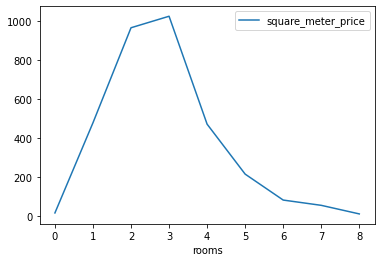

In [212]:
rooms_spb_center_pivot.query('rooms<=8').plot()

#### Взаимосвязь удаленности от центра и цены квадратного метра. 

In [213]:
spb_center_data['square_meter_price'].corr(spb_center_data['cityCenters_nearest'])

-0.02945163400317123

#### Взаимосвязь года размещения объявления и цены квадратного метра. 

In [214]:
year_spb_center_pivot=spb_center_data.pivot_table(index='year_exposition', values='square_meter_price', aggfunc='mean')
year_spb_center_pivot.sort_values(by='year_exposition', ascending=True)

,square_meter_price
year_exposition,
2014,195689.94
2015,145884.42
2016,138011.07
2017,143136.04
2018,141078.34
2019,162824.10


<AxesSubplot:xlabel='year_exposition'>

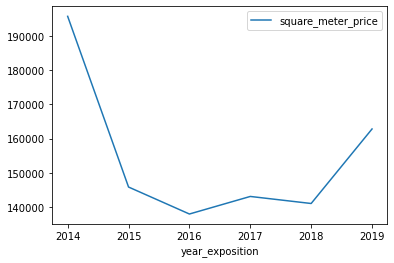

In [215]:
year_spb_center_pivot.plot()

Общее падение цены за квадратный метр касается также и квартир в центре. 

## Общий вывод

- Ни один из параметров не оказывает ключевое влияние на цену квадратного метра. 
- Наибольшее влияние у фактора общей цены: у тех квартир, что сами по себе дороже, выше и цена квадратного метра. 

Посмотрим на параметры, вообще оказывающие влияние на цену: 

In [216]:
data.corrwith(data['last_price']).to_frame().style.background_gradient(cmap="coolwarm")

,0
total_images,0.104485
last_price,1.000000
total_area,0.653838
rooms,0.363483
ceiling_height,0.260189
floors_total,-0.007049
living_area,0.585854
floor,0.026632
is_apartment,0.027516
studio,-0.025377
